In [1]:
# pip install rasterio numpy matplotlib scikit-learn geopandas

In [2]:
# pip install folium geopandas rasterio shapely geojson

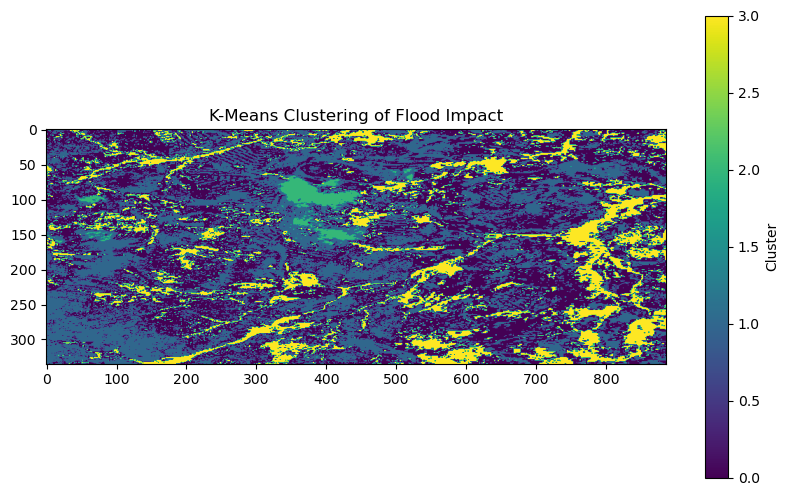

Clustered GeoTIFF saved as Flood_Impact_Clusters.tif


In [3]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define file paths for GeoTIFFs
ndwi_file = "NDWI_Change_Map.tif"
ndvi_file = "NDVI_Change_Map.tif"
ndbi_file = "NDBI_Change_Map.tif"

# Function to load raster data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first band
        profile = src.profile  # Get metadata
    return data, profile

# Load NDWI, NDVI, and NDBI change maps
ndwi_data, profile = load_raster(ndwi_file)
ndvi_data, _ = load_raster(ndvi_file)
ndbi_data, _ = load_raster(ndbi_file)

# Flatten raster data for clustering (only non-NaN pixels)
valid_mask = (~np.isnan(ndwi_data)) & (~np.isnan(ndvi_data)) & (~np.isnan(ndbi_data))
features = np.column_stack([
    ndwi_data[valid_mask].flatten(),
    ndvi_data[valid_mask].flatten(),
    ndbi_data[valid_mask].flatten()
])

# Apply K-Means clustering
num_clusters = 4  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features)

# Create clustered image
clustered_image = np.full(ndwi_data.shape, np.nan)
clustered_image[valid_mask] = clusters

# Save clustered image as a GeoTIFF
profile.update(dtype=rasterio.uint8, count=1)
clustered_file = "Flood_Impact_Clusters.tif"
with rasterio.open(clustered_file, "w", **profile) as dst:
    dst.write(clustered_image.astype(rasterio.uint8), 1)

# Plot clustered image
plt.figure(figsize=(10, 6))
plt.imshow(clustered_image, cmap="viridis")
plt.colorbar(label="Cluster")
plt.title("K-Means Clustering of Flood Impact")
plt.show()
print(f"Clustered GeoTIFF saved as {clustered_file}")

### HDBSCAN

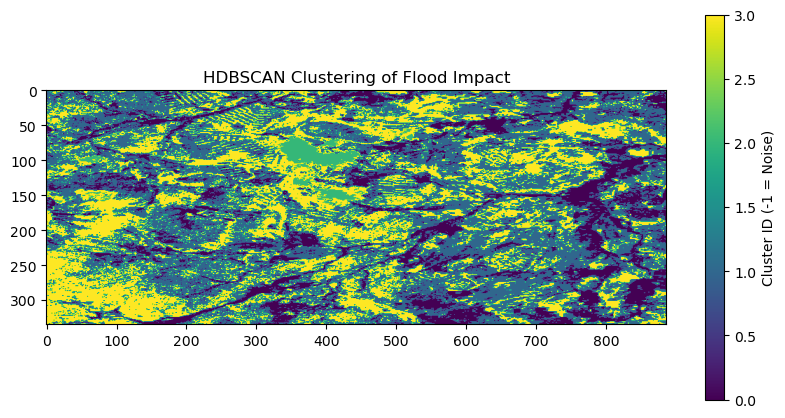

Clusters Found: {0: 51935, 1: 146076, 2: 4382, 3: 94752}
Clustered GeoTIFF saved as Flood_Impact_HDBSCAN.tif


In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.preprocessing import MinMaxScaler

# Load the Flood Impact GeoTIFF
filename = "Flood_Impact_Clusters.tif"

with rasterio.open(filename) as src:
    flood_data = src.read(1)  # Read first band (assumed to be NDWI/NDVI/NDBI change)
    profile = src.profile  # Save metadata

# Flatten the data and remove NaN values
valid_pixels = ~np.isnan(flood_data)
X = flood_data[valid_pixels].reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply HDBSCAN Clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20)
labels = hdbscan_clusterer.fit_predict(X_scaled)

# Initialize clustered image with -1 (noise)
clustered_image = np.full(flood_data.shape, -1, dtype=np.int32)
clustered_image[valid_pixels] = labels  # Assign labels to valid pixels

# Save Clustered Image as GeoTIFF
output_filename = "Flood_Impact_HDBSCAN.tif"
profile.update(dtype=rasterio.int32, count=1)

with rasterio.open(output_filename, 'w', **profile) as dst:
    dst.write(clustered_image, 1)

# Plot Results
plt.figure(figsize=(10, 5))
plt.title("HDBSCAN Clustering of Flood Impact")
plt.imshow(clustered_image, cmap="viridis")
plt.colorbar(label="Cluster ID (-1 = Noise)")
plt.show()

# Check cluster distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print("Clusters Found:", dict(zip(unique_labels, counts)))
print(f"Clustered GeoTIFF saved as {output_filename}")

In [6]:
import numpy as np
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([ 51935, 146076,   4382,  94752], dtype=int64))

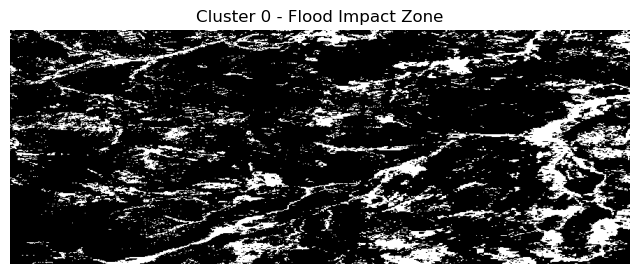

Cluster 0 saved as Flood_Clusters\Cluster_0.tif


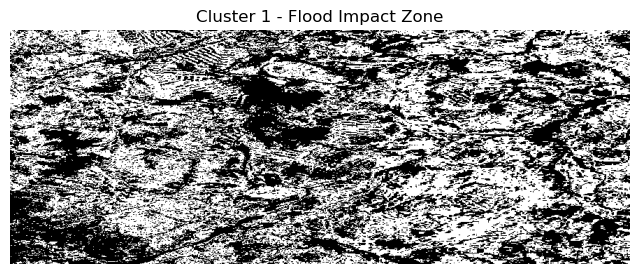

Cluster 1 saved as Flood_Clusters\Cluster_1.tif


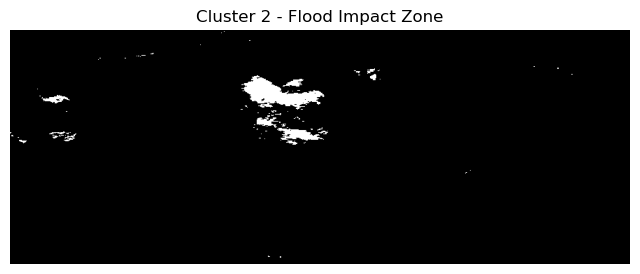

Cluster 2 saved as Flood_Clusters\Cluster_2.tif


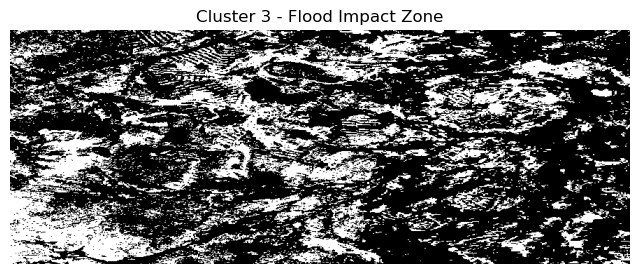

Cluster 3 saved as Flood_Clusters\Cluster_3.tif


In [7]:
import os

# Define the input clustered image
clustered_file = "Flood_Impact_HDBSCAN.tif"

# Load the clustered flood impact image
with rasterio.open(clustered_file) as src:
    clustered_data = src.read(1)  # Read the first band
    profile = src.profile  # Get metadata

# Create an output folder
output_folder = "Flood_Clusters"
os.makedirs(output_folder, exist_ok=True)

# Extract unique cluster labels, ignoring noise (-1)
unique_clusters = np.unique(clustered_data)
unique_clusters = unique_clusters[unique_clusters != -1]  # Ignore noise if present

# Plot and save each cluster separately
for cluster_id in unique_clusters:
    cluster_mask = (clustered_data == cluster_id).astype(np.uint8) * 255  # Convert to binary mask

    # Save individual cluster as a new GeoTIFF
    cluster_filename = os.path.join(output_folder, f"Cluster_{int(cluster_id)}.tif")
    profile.update(dtype=rasterio.uint8, count=1)

    with rasterio.open(cluster_filename, "w", **profile) as dst:
        dst.write(cluster_mask, 1)

    # Plot the cluster
    plt.figure(figsize=(8, 5))
    plt.imshow(cluster_mask, cmap="gray")
    plt.title(f"Cluster {int(cluster_id)} - Flood Impact Zone")
    plt.axis("off")
    plt.show()

    print(f"Cluster {int(cluster_id)} saved as {cluster_filename}")

In [9]:
print("Unique clusters found:", unique_clusters)


Unique clusters found: [0 1 2 3]


In [3]:
import rasterio
import numpy as np
import pandas as pd
import os

# Define input folder
input_folder = "Flood_Clusters"

# Severity labels (Adjust based on actual observations)
severity_labels = {
    0: "Severe Flooding",
    1: "Moderate Flooding",
    2: "Mild Impact",
    3: "No Significant Damage"
}

# Initialize results list
cluster_stats = []

# Process each cluster file
for cluster_id in severity_labels.keys():
    file_path = os.path.join(input_folder, f"Cluster_{cluster_id}.tif")
    
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)  # Read first band
            pixel_count = np.count_nonzero(data > 0)  # Count all non-zero pixels
            total_pixels = data.size  # Total number of pixels in the raster
            flood_coverage = (pixel_count / total_pixels) * 100  # Percentage of area affected

            cluster_stats.append([cluster_id, pixel_count, flood_coverage, severity_labels[cluster_id]])

# Convert to DataFrame and display the table
df = pd.DataFrame(cluster_stats, columns=["Cluster_ID", "Pixel_Count", "Flood Coverage (%)", "Flood_Severity"])
df["Flood Coverage (%)"] = df["Flood Coverage (%)"].round(2)

# Print the table
print(df.to_string(index=False))

 Cluster_ID  Pixel_Count  Flood Coverage (%)        Flood_Severity
          0        51935               17.48       Severe Flooding
          1       146076               49.16     Moderate Flooding
          2         4382                1.47           Mild Impact
          3        94752               31.89 No Significant Damage


In [2]:
import rasterio
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import json
from shapely.geometry import shape, mapping
from geojson import Feature, FeatureCollection
import concurrent.futures

# Open raster file
with rasterio.open('Flood_Impact_Clusters.tif') as src:
    data = src.read(1)  # Read the first band
    transform = src.transform
    height, width = data.shape

# Tile size (300x300)
tile_size = 500

# MiniBatchKMeans (faster for large data)
kmeans = MiniBatchKMeans(n_clusters=3, batch_size=10000, random_state=42)

# Function to process a tile
def process_tile(row_start, row_end, col_start, col_end):
    # Extract the tile data
    tile = data[row_start:row_end, col_start:col_end]
    tile_flat = tile.flatten().reshape(-1, 1)

    # Run KMeans clustering on the tile
    labels = kmeans.fit_predict(tile_flat)

    # Reshape labels to match tile shape
    labels_reshaped = labels.reshape((row_end - row_start, col_end - col_start))

    # Convert the clustering output to GeoJSON features
    features = []
    for row in range(row_end - row_start):
        for col in range(col_end - col_start):
            value = int(labels_reshaped[row, col])  # Convert to Python int
            x, y = src.xy(row + row_start, col + col_start)
            polygon = shape({'type': 'Polygon', 'coordinates': [[(x, y), (x+1, y), (x+1, y+1), (x, y+1), (x, y)]]})
            feature = Feature(geometry=polygon, properties={'cluster_id': value})
            features.append(feature)

    return features

# Function to divide the raster into tiles and process them in parallel
def process_raster():
    features = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for row_start in range(0, height, tile_size):
            for col_start in range(0, width, tile_size):
                row_end = min(row_start + tile_size, height)
                col_end = min(col_start + tile_size, width)
                futures.append(executor.submit(process_tile, row_start, row_end, col_start, col_end))

        # Collect all results from the futures
        for future in concurrent.futures.as_completed(futures):
            features.extend(future.result())

    # Convert to GeoJSON
    geojson_output = FeatureCollection(features)
    return geojson_output

# Run the process and save to file
geojson_output = process_raster()

# Convert the GeoJSON output to a JSON string
with open('flood_clusters.geojson', 'w') as f:
    json.dump(geojson_output, f)

print("GeoJSON file created.")

GeoJSON file created.
